In [1]:
#@title Imports and Initialization
# %pip install datasets
# %pip install textwrap
# %pip install openai
# %pip install scipy
# %pip install matplotlib

import collections
from abc import ABC
import datasets
import json
import openai
import numpy as np
from scipy.special import softmax
import textwrap
import matplotlib.pyplot as plt
from IPython.display import clear_output

OPENAI_SECRET_KEY = None

clear_output()

# Setup the OpenAI API

1. Go to www.openai.com and log into your account.
2. Go to https://platform.openai.com/account/api-keys and click the "Create new secret key" button. It doesn't matter what you name it.
3. Copy your API key, and then run the code block below. It will ask you to enter your secret key into a text box.

In [4]:
if OPENAI_SECRET_KEY is None:
  print("Please paste your OpenAI API key here:")
  OPENAI_SECRET_KEY = input().strip()
openai.api_key = OPENAI_SECRET_KEY
clear_output()

class OpenAIEngine():
  def __init__(self, model_name):
    self.model_name = model_name

  def score(self, text):
    """Tokenizes and scores a piece of text.

    This only works for the OpenAI models which support the legacy `Completion`
    API.

    The score is log-likelihood. A higher score means a token was more
    likely according to the model.

    Returns a list of tokens and a list of scores.
    """
    response = openai.Completion.create(
        engine=self.model_name,
        prompt=text,
        max_tokens=0,
        logprobs=1,
        echo=True)

    tokens = response["choices"][0]["logprobs"]["tokens"]
    logprobs = response["choices"][0]["logprobs"]["token_logprobs"]
    if logprobs and logprobs[0] is None:
      # GPT-3 API does not return logprob of the first token
      logprobs[0] = 0.0
    return tokens, logprobs

  def perplexity(self, text):
    """Compute the perplexity of the provided text."""
    completion = openai.Completion.create(
        model=self.model_name,
        prompt=text,
        logprobs=0,
        max_tokens=0,
        temperature=1.0,
        echo=True)
    token_logprobs = completion['choices'][0]['logprobs']['token_logprobs']
    nll = np.mean([i for i in token_logprobs if i is not None])
    ppl = np.exp(-nll)
    return ppl

  def generate(self,
               prompt,
               top_p=1.0,
               num_tokens=32,
               num_samples=1,
               frequency_penalty=0.0,
              presence_penalty=0.0):
    """Generates text given the provided prompt text.

    This only works for the OpenAI models which support the legacy `Completion`
    API.

    If num_samples is 1, a single generated string is returned.
    If num_samples > 1, a list of num_samples generated strings is returned.
    """
    response = openai.Completion.create(
      engine=self.model_name,
      prompt=prompt,
      temperature=1.0,
      max_tokens=num_tokens,
      top_p=top_p,
      n=num_samples,
      frequency_penalty=frequency_penalty,
      presence_penalty=presence_penalty,
      logprobs=1,
    )
    outputs = [r["text"] for r in response["choices"]]
    return outputs[0] if num_samples == 1 else outputs


  def chat_generate(self,
                    previous_messages,
                    top_p=1.0,
                    num_tokens=32,
                    num_samples=1,
                    frequency_penalty=0.0,
                    presence_penalty=0.0):
    response = openai.ChatCompletion.create(
      model=self.model_name,
      messages=previous_messages,
      temperature=1.0,
      max_tokens=num_tokens,
      top_p=top_p,
      frequency_penalty=frequency_penalty,
      presence_penalty=presence_penalty,
      n=num_samples,
    )
    return response

# Question 1: Observing the Impact of Decoding Strategy

## 1.1: Rolling a Twenty-Sided Die

In [5]:
MODEL_NAME = "davinci-002"
engine = OpenAIEngine(MODEL_NAME)

In [458]:
number_map = {
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "eleven": 11,
    "twelve": 12,
    "thirteen": 13,
    "fourteen": 14,
    "fifteen": 15,
    "sixteen": 16,
    "seventeen": 17,
    "eighteen": 18,
    "nineteen": 19,
    "twenty": 20
}

In [955]:
# prompt = "Let's roll a D20. The die shows the number"
# prompt = "Let's roll a D20, which randomly get a number from 1 to 20, the number is?"
# prompt = "Let's roll a D20, which number does this die show?"
prompt = "Let's roll a D20, the number is"
rolls = engine.generate(prompt, num_tokens=2, num_samples=128, top_p=0.2)
# rolls = engine.generate(prompt, num_samples=128, top_p=0.8)
expected_number_of_outcomes = 20

In [956]:
rolls_counter = collections.Counter()

for roll in rolls:
  try:
    roll_num = int(roll.strip())
    # Let's label invalid numbers as -1
    roll_num = roll_num if 1 <= roll_num <= 20 else -1
  except ValueError:
    # Let's just label invalid generation as a roll of -1.
    if (number_map.get(roll.lower().strip())):
        roll_num = number_map.get(roll.lower().strip());
    else:
        roll_num = -1
  rolls_counter[roll_num] += 1

print(rolls_counter)
print("Percentage of valid outcomes generated:",
      (len(rolls_counter)-1)/expected_number_of_outcomes)

Counter({-1: 47, 15: 32, 10: 26, 20: 23})
Percentage of valid outcomes generated: 0.15


In [957]:
set(rolls)

{' 10', ' 15', ' 20', ' the number'}

In [958]:
for roll in rolls:
    print(roll)

 the number
 15
 15
 15
 20
 the number
 10
 the number
 10
 10
 the number
 15
 20
 10
 10
 10
 15
 15
 20
 the number
 the number
 the number
 the number
 10
 15
 10
 20
 15
 the number
 the number
 15
 20
 the number
 15
 the number
 10
 the number
 15
 20
 10
 10
 the number
 the number
 20
 15
 15
 10
 the number
 the number
 10
 the number
 the number
 20
 10
 the number
 15
 10
 15
 15
 15
 20
 the number
 the number
 20
 10
 10
 the number
 15
 20
 15
 20
 10
 20
 10
 the number
 the number
 15
 10
 the number
 the number
 10
 15
 the number
 the number
 the number
 the number
 20
 the number
 the number
 the number
 the number
 20
 15
 15
 the number
 the number
 15
 20
 20
 the number
 10
 10
 15
 15
 20
 the number
 the number
 15
 the number
 15
 10
 15
 10
 the number
 15
 20
 20
 15
 20
 20
 20
 the number
 10
 15
 the number
 the number
 the number
 the number


In [959]:
def get_valid_counter(counter):
    # Define the value to remove
    value_to_remove = -1

    # Get the frequency of the value to remove
    frequency_to_remove = counter[value_to_remove]

    # Remove the value from the Counter
    counter.subtract({value_to_remove: frequency_to_remove})

    # Remove any negative counts (optional)
    for key in list(counter):
        if counter[key] <= 0:
            del counter[key]

    return(counter)

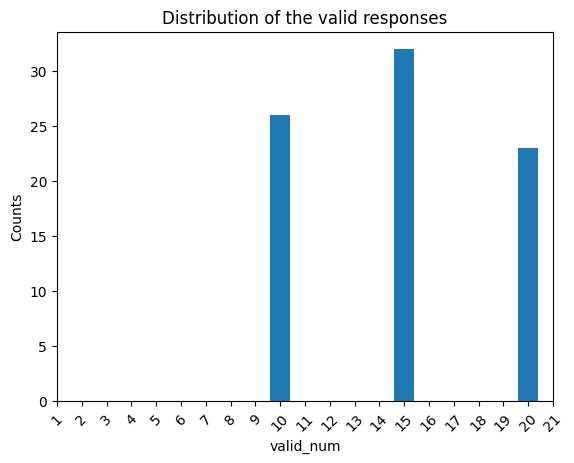

In [960]:
# unique_tokens, counts = np.unique(rolls, return_counts=True)
valid_counter = get_valid_counter(rolls_counter)
valid_num, counts = zip(*valid_counter.items())

# str_num = [str(num) for num in valid_num]

plt.bar(valid_num, counts)
plt.xlabel('valid_num')
plt.ylabel('Counts')
plt.title('Distribution of the valid responses')
plt.xticks(rotation=45)
plt.xticks(range(1, 22))
plt.show()

In [736]:
# try random generation
import random

rand_counter = collections.Counter()

for i in range(40):
    rand = random.randint(1, 20)
    rand_counter[rand] += 1
    # print(i)

print(rand_counter)
print("Percentage of valid outcomes generated:",
      (len(rand_counter)-1)/expected_number_of_outcomes)

Counter({17: 4, 19: 4, 12: 4, 6: 3, 1: 3, 11: 3, 16: 3, 13: 2, 4: 2, 9: 2, 8: 2, 14: 2, 7: 1, 20: 1, 10: 1, 3: 1, 18: 1, 2: 1})
Percentage of valid outcomes generated: 0.85


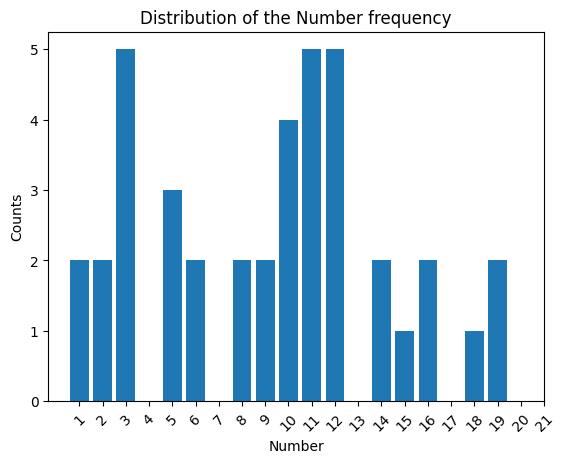

In [607]:
num, counts = zip(*rand_counter.items())

# str_num = [str(num) for num in valid_num]

plt.bar(num, counts)
plt.xlabel('Number')
plt.ylabel('Counts')
plt.title('Distribution of the Number frequency')
plt.xticks(rotation=45)
plt.xticks(range(min(valid_num), 22))
plt.show()

## 1.2: Longform Generation

In [16]:
import math

def calculate_ttr(text):
    words = text.split()
    unique_words = set(words)
    ttr = len(unique_words) / len(words)
    return ttr

def calculate_malones_measure(text):
    words = text.split()
    unique_words = set(words)
    d = 1 - (len(unique_words) / len(words))
    return d

def calculate_herdans_c(text):
    words = text.split()
    unique_words = set(words)
    vocabulary_size = len(unique_words)
    n = len(words)
    c = vocabulary_size / math.sqrt(n)
    return c

In [68]:
def output_res(res, top_p, frequency_penalty):
    print(f'Response: {res}\n')
    print(f'top_p = {top_p}')
    print(f'frequency_penalty = {frequency_penalty}')
    print(f'TTR: {calculate_ttr(res)}')
    # print(f'Malone\'s Measure: {calculate_malones_measure(res)}')
    # print(f'Herdan\'s C: {calculate_herdans_c(res)}')

### Using a prompt of your choice, instruct the language model to generate a 256-token story.

In [60]:
# Prompt with top_p = 0.0
prompt = "Once upon a time, there is a scientist wanting to create a time machine"
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=0.0)

output_res(res, 0.0)

Response: . He has a lot of money and he is very smart. He has a lot of ideas and he is very creative. He has a lot of time and he is very patient. He has a lot of people and he is very friendly. He has a lot of materials and he is very rich. He has a lot of time and he is very patient. He has a lot of money and he is very rich. He has a lot of people and he is very friendly. He has a lot of ideas and he is very creative. He has a lot of materials and he is very rich. He has a lot of time and he is very patient. He has a lot of money and he is very rich. He has a lot of people and he is very friendly. He has a lot of ideas and he is very creative. He has a lot of materials and he is very rich. He has a lot of time and he is very patient. He has a lot of money and he is very rich. He has a lot of people and he is very friendly. He has a lot of ideas and he is very creative. He has a lot of materials and he is very rich. He has a lot of time and he is very patient. He has a

top_p = 0.0


In [61]:
# Prompt with top_p = 0.5
prompt = "Once upon a time, there is a scientist wanting to create a time machine"
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.5, frequency_penalty=0.0)
output_res(res, 0.5)

Response: . He found a way to do it, but he also found out that the time machine is not able to go back in time. The scientist was so disappointed. But he found out that the time machine can go forward in time. So he started to create a new time machine that can go forward in time. The scientist created a new time machine and it was able to go forward in time. He was so happy.

But the scientist also found out that the time machine is not able to go forward in time. He was so disappointed. He thought about it and thought about it. He finally found out that the time machine can go forward in time. So he started to create a new time machine that can go forward in time. The scientist created a new time machine and it was able to go forward in time. He was so happy.

But the scientist also found out that the time machine is not able to go forward in time. He was so disappointed. He thought about it and thought about it. He finally found out that the time machine can go forward in time. So 

In [62]:
# Prompt with top_p = 1.0
prompt = "Once upon a time, there is a scientist wanting to create a time machine"
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=1.0, frequency_penalty=0.0)
output_res(res, 1.0)

Response:  to butterfly effect his time interpreting the phrase ‘I’m confident.’ followed by the sentence, “Because I’ve got a time machine.” three years ago. He built the time machine but as he figured to manipulate it accordingly, it played cat and mouse mentality with him (as if it really occurs) by jumping back a fourth year, second month, third day until chaos rules this contorted sort of timeline. It crossed with the other son of a time traveller - Kay Murphy II. Realising this is a self-consistent rotating plot paradox, everything's tidy in this timeline. However, it quizzes the scientist and the time machine. The scientist tried to breaking in and busting open the time machine right away but it didn’t help at all. Quickly he sensed the scientist’s blunder and then cut the chain. Whilst the time machine nudged away and being mashed time up, the scientist seems rather unconcerned knowing that one of his kind is here. He flipped the switch and left.. Thug leaves a letter for Kay’s

### prompt the language model with the opening sentence from a renowned book or speech

In [63]:
# prompt = "It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness,"
# Prompt with top_p = 0.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=0.0)
output_res(res, 0.0)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day even the state of Mississippi, a desert state, sweltering with the heat of injustice and oppression, will be transformed into an oasis of freedom and justice. I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character. I have a dream today. I have a dream that one day, down in Alabama, with its vicious racists, with its governor having his lips dripping with the words of interposition and nullification; one day right there in Alabama little black boys and black girls will be able to join hands with little white boys and white girls as sisters and brothers. I have a dream today. I have a dream that one day every valley shall be exalted, every hill and mountain sh

In [64]:
# Prompt with top_p = 0.5
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.5, frequency_penalty=0.0)
output_res(res, 0.5)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day even the state of Mississippi, a desert state, sweltering with the heat of injustice and oppression, will be transformed into an oasis of freedom and justice. I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character. I have a dream today.

“When we let freedom ring, when we let it ring from every village and every hamlet, from every state and every city, we will be able to speed up that day when all of God’s children, black men and white men, Jews and Gentiles, Protestants and Catholics, will be able to join hands and sing in the words of the old Negro spiritual, ‘Free at last! Free at last! Thank God Almighty, we are free at last!’”

It was the most famous sp

In [65]:
# Prompt with top_p = 1.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=1.0, frequency_penalty=0.0)
output_res(res, 1.0)

Response:  12 'We shall overcome': Read civil rights great still 'rattling in the rusted-out cans of a Jim Crow era'

Donald Trump compares his fantasy border to the wall of China

Former Trump employee's George Papadopoulos says Trump a 'skilled conservator of destructive impulses'

Trump adviser Flynn gives first interview since pleading guilty to lying to FBI

The Russians invaded the US election and succeeded. Trump started with talking and selling, and moved to blackmail, threats, and finally the actual rigging of the election, which has he benefited from enormously. Nixon warned not to start the process of demanding something you can’t get; then step by step he is radicalsized into doing things that lead to Watergate. Grossmann — Russia 2018 – What to watch for in Sunday’s vote in Russia

How Donald Trump tested the Republican Party and found it wanting.

Trump pick for VA heads to confirmation fight after admitting to severe PTSD

I think Trump dislikes the media for the same re

In [66]:
# Prompt with top_p = 0.0, frequency_penalty = 0.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=0.0)
output_res(res, 1.0)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day even the state of Mississippi, a desert state, sweltering with the heat of injustice and oppression, will be transformed into an oasis of freedom and justice. I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character. I have a dream today. I have a dream that one day, down in Alabama, with its vicious racists, with its governor having his lips dripping with the words of interposition and nullification; one day right there in Alabama little black boys and black girls will be able to join hands with little white boys and white girls as sisters and brothers. I have a dream today. I have a dream that one day every valley shall be exalted, every hill and mountain sh

In [76]:
# Prompt with top_p = 0.0, frequency_penalty = 0.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=0.0)
output_res(res, 0.0, 0.0)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day even the state of Mississippi, a desert state, sweltering with the heat of injustice and oppression, will be transformed into an oasis of freedom and justice. I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character. I have a dream today. I have a dream that one day, down in Alabama, with its vicious racists, with its governor having his lips dripping with the words of interposition and nullification; one day right there in Alabama little black boys and black girls will be able to join hands with little white boys and white girls as sisters and brothers. I have a dream today. I have a dream that one day every valley shall be exalted, every hill and mountain sh

In [77]:
# Prompt with top_p = 0.0, frequency_penalty = 1.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=1.0)
output_res(res, 0.0, 1.0)

Response:  I have a dream that one day on the red hills of Georgia, the sons of former slaves and the sons of former slave owners will be able to sit down together at a table of brotherhood. I have a dream that one day even the state of Mississippi, a desert state sweltering with the heat of injustice and oppression, will be transformed into an oasis of freedom and justice. I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character.

I Have A Dream Speech - Martin Luther King Jr., August 28 1963





top_p = 0.0
frequency_penalty = 1.0
TTR: 0.6271186440677966


In [78]:
# Prompt with top_p = 0.0, frequency_penalty = 2.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=2.0)
output_res(res, 0.0, 2.0)

Response:  I have a dream that one day on the red hills of Georgia, sons of former slaves and the sons of former slave owners will be able to sit down together at a table of brotherhood.

I have a dream that one day even the state with its iron fist in Mississippi will be transformed into an oasis for freedom and justice. I have a dream today!





top_p = 0.0
frequency_penalty = 2.0
TTR: 0.6716417910447762


In [80]:
# Prompt with top_p = 0.0, frequency_penalty = -1.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=-1.0)
output_res(res, 0.0, -1.0)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day even the state of Mississippi, a state sweltering with the heat of injustice, sweltering with the heat of oppression, will be transformed into an oasis of freedom and the of the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

In [81]:
# Prompt with top_p = 0.0, frequency_penalty = 2.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=-2.0)
output_res(res, 0.0, -2.0)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day the state of the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

# Question 2: Measuring Perplexity

In [35]:
MODEL_NAME = "davinci"
engine = OpenAIEngine(MODEL_NAME)

In [36]:
poem = """
’Twas brillig, and the slithy toves
      Did gyre and gimble in the wabe:
All mimsy were the borogoves,
      And the mome raths outgrabe.

“Beware the Jabberwock, my son!
      The jaws that bite, the claws that catch!
Beware the Jubjub bird, and shun
      The frumious Bandersnatch!”

He took his vorpal sword in hand;
      Long time the manxome foe he sought—
So rested he by the Tumtum tree
      And stood awhile in thought.

And, as in uffish thought he stood,
      The Jabberwock, with eyes of flame,
Came whiffling through the tulgey wood,
      And burbled as it came!

One, two! One, two! And through and through
      The vorpal blade went snicker-snack!
He left it dead, and with its head
      He went galumphing back.

“And hast thou slain the Jabberwock?
      Come to my arms, my beamish boy!
O frabjous day! Callooh! Callay!”
      He chortled in his joy.

’Twas brillig, and the slithy toves
      Did gyre and gimble in the wabe:
All mimsy were the borogoves,
      And the mome raths outgrabe.
"""

engine.perplexity(poem)

1.339475969608505

# Question 3: Experimenting with Few-Shot Prompting

## 3.1: Few-Shot Learning for the Choice of Plausible Alternatives Task

In [4]:
copa_dataset = datasets.load_dataset("super_glue", "copa")

# You may draw on these examples to produce few-shot prompts.
train_data = copa_dataset["train"].shuffle(seed=1).select(range(50))

# Use this development set to try out different few-shot prompts to see
# what works best.
dev_data = copa_dataset["train"].shuffle(seed=1).select(range(50, 150))

# You should only use this at the end during final evaluation to generate
# accuracies to put in your report.
test_data = copa_dataset["validation"].shuffle(seed=1).select(range(100))

print("Some examples from the train set:")
for i in range(3):
  print(json.dumps(train_data[i], indent=2))

Some examples from the train set:
{
  "premise": "The woman spotted her friend from across the room.",
  "choice1": "The woman waved.",
  "choice2": "The woman escaped.",
  "question": "cause",
  "idx": 379,
  "label": 0
}
{
  "premise": "The girl made a wish.",
  "choice1": "She saw a black cat.",
  "choice2": "She saw a shooting star.",
  "question": "cause",
  "idx": 45,
  "label": 1
}
{
  "premise": "The woman hired a lawyer.",
  "choice1": "She decided to sue her employer.",
  "choice2": "She decided to run for office.",
  "question": "cause",
  "idx": 39,
  "label": 0
}


In [ ]:
prompt = "Given the following premise and cause, label whether the cause seems correct\n\n"
eval_template = "Review: {review}\nSentiment: {sentiment}"

In [ ]:
def classify_baseline(premise: str, choice1: str, choice2:str) -> str:
  """ Given a review, returns a sentiment prediction, 0 for negative, 1 for positive."""

  eval_template = """Which of the following makes more sense?

  Choice 1: {premise} This happened because: {choice1}
  Choice 2: {premise} This happened because: {choice2}

  {label} makes more sense.
  """
  label_map = {0: "Choice 1", 1: "Choice 2"}

  label_to_score = {}
  for label, label_str in label_map.items():
    label_prompt = prompt + eval_template.format(
        premise=premise, choice1=choice1, choice2=choice2, label=label_str)
    _, score = engine.score(label_prompt)
    llm_score_for_label = np.mean(score)

    label_to_score[label] = llm_score_for_label

  return max(label_to_score, key=label_to_score.get)


def evaluate(dataset, verbose: bool=False) -> float:
  """ Evaluate your prompt on the test set """
  correct = []
  for i, instance in enumerate(dataset):
    label = instance["label"]
    predicted = classify_baseline(
        instance["premise"], instance["choice1"], instance["choice2"])
    correct.append(1 if label == predicted else 0)

    if verbose:
      print(f"======== {i+1} / {len(dataset)} ========")
      print(f"PREMISE: {instance['premise']}")
      print(f"CHOICE 1 {'✅' if not label else '❌'}: {instance['choice1']}")
      print(f"CHOICE 2 {'✅' if label else '❌'}: {instance['choice2']}")
      print(f"PREDICTED: {'choice 2' if predicted else 'choice 1'}")

  acc = sum(correct) / len(correct)
  return acc

#  Once you have chosen your prompts, for final evaluation, replace dev_data
# with test_data.
acc = evaluate(dev_data, verbose=True)
print(f"Accuracy of your prompt on {len(test_data)} test examples: {acc:.0%}")

======== 1 / 100 ========
PREMISE: My car was towed.
CHOICE 1 ✅: I parked illegally.
CHOICE 2 ❌: I jumped the battery.
PREDICTED: choice 2
======== 2 / 100 ========
PREMISE: I rubbed the soap between my hands.
CHOICE 1 ✅: The soap foamed.
CHOICE 2 ❌: My hands went numb.
PREDICTED: choice 2
======== 3 / 100 ========
PREMISE: The stain came out of the shirt.
CHOICE 1 ❌: I patched the shirt.
CHOICE 2 ✅: I bleached the shirt.
PREDICTED: choice 2
======== 4 / 100 ========
PREMISE: The police closed the investigation.
CHOICE 1 ✅: They apprehended the suspect.
CHOICE 2 ❌: The victim recovered.
PREDICTED: choice 2
======== 5 / 100 ========
PREMISE: My foot went numb.
CHOICE 1 ❌: I put my shoes on.
CHOICE 2 ✅: I shook my foot.
PREDICTED: choice 2
======== 6 / 100 ========
PREMISE: The hospital sent the patient home.
CHOICE 1 ✅: The patient's symptoms cleared up.
CHOICE 2 ❌: The patient's family visited him.
PREDICTED: choice 2
======== 7 / 100 ========
PREMISE: The parents recognized their daug